# Draft `pyGIMLi(emg3d)`

**NEEDS**
- `pyGIMLi`
- `emg3d`
- `discretize`
- `xarray`
- `h5py`

**Current Limitations**
- Only isotropic models supported
- Only 'Conductivity' models supported
- Without el. perm. and magn. perm.

An attempt at using `pyGIMLi` as an inversion framework for `emg3d` computations.

For developping purposes, we take a very simple grid/model/survey:
- Coarse mesh, no stretching (potentially too small).
- Simple double-halfspace model water-subsurface with a resistive block.
- Survey: A single 2D line, 5 sources (3 in the coarse one), 1 frequency.

=> For this dev-implementation we also do inversion crime, using the same grid for forward modelling and inversion.

In [156]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm

import emg3d
import pygimli as pg
from pygimli.frameworks.lsqrinversion import LSQRInversion

In [157]:
# %matplotlib notebook

## Load survey (incl. data), initial model, and create a Simulation

In [158]:
#inp_data = emg3d.load('pginv.h5')        # Finer model (but still coarse)
inp_data = emg3d.load('pginv-coarse.h5')  # VERY COARSE (to develop)

inp_survey = inp_data['survey']
inp_model = inp_data['model']
inp_grid = inp_model.grid
inp_model

Data loaded from «c:\Guenther.T\src\gimli\dev-pygimli-emg3d\pginv-coarse.h5»
[emg3d vunknown-20231214 (format 1.0) on 2023-12-14T12:36:23.717607].


Model: resistivity; isotropic; 32 x 16 x 16 (8,192)

In [159]:
# The model is resistivity. Change it to conductivity
# TODO: make this internally happen, so that pyGIMLi
# always gets a conductivity model!
con_model = emg3d.Model(inp_grid, 1/inp_model.property_x, mapping='Conductivity')
con_model

Model: conductivity; isotropic; 32 x 16 x 16 (8,192)

In [160]:
# For dev-purposes, we only select one source
# [for dev-purposes it is also a very simple model]
inp_survey = inp_survey.select(sources='TxED-1')
inp_survey

:: Survey ::

<xarray.Dataset>
Dimensions:   (src: 1, rec: 50, freq: 1)
Coordinates:
  * src       (src) <U6 'TxED-1'
  * rec       (rec) <U7 'RxEP-01' 'RxEP-02' 'RxEP-03' ... 'RxEP-56' 'RxEP-57'
  * freq      (freq) <U3 'f-1'
Data variables:
    observed  (src, rec, freq) complex128 (-4.787602447206279e-10+8.548625928...
Attributes:
    noise_floor:     1e-17
    relative_error:  0.05

## Create a Simulation

In [161]:
# Create an emg3d Simulation instance
sim = emg3d.simulations.Simulation(
    survey=inp_survey,
    model=con_model,
    gridding='same',  # I would like to make that more flexible in the future
    max_workers=4,    # Adjust as needed
    receiver_interpolation='linear',  # Currently necessary for the gradient
    #solver_opts={'plain': True, 'maxit': 1},  # Just for dev-purpose
    #solver_opts={'tol': 1e-4},                # Just for dev-purpose
    tqdm_opts=False,  # Switch off verbose progress bars
)

## Jacobian Wrapper (should move to a py-file)

In [162]:
class JacobianXemg3d(pg.Matrix):
    """Create a Jacobian operator to use emg3d as kernel within pyGIMLi."""
    
    def __init__(self, sim):
        super().__init__()
        self.sim = sim

    def cols(self):
        # sim.model.size corresponds to the number of cells
        return self.sim.model.size

    def rows(self):
        # sim.survey.count corresponds to the number of non-NaN data points.
        # Multiply by 2 for real + imaginary parts.
        return self.sim.survey.count * 2

    def mult(self, x):
        """J * x """
        # - Input x has size of the model; later, we want to generalize that
        #   to allow for anisotropic models etc.
        # - Output has size of non-NaN data [Re, Im]
        jvec = self.sim.jvec(np.reshape(x, self.sim.model.shape, order='F'))
        data = jvec[self.sim._finite_data]
        return np.hstack((data.real, data.imag))

    def transMult(self, x):
        """J.T * x = (x * J.T)^T """
        # - Input has size of non-NaN data [Re, Im]
        # - Output has size of the model
        data = np.ones(self.sim.survey.shape, dtype=self.sim.data.observed.dtype)*np.nan
        x = np.asarray(x)
        data[self.sim._finite_data] = x[:x.size//2] + 1j*x[x.size//2:]
        return self.sim.jtvec(data).ravel('F')
    
    def save(self, *args):
        pass

## Forward Wrapper (should move to a py-file)

In [163]:
class KernelXemg3d(pg.Modelling):
    """Create a forward operator to use emg3d as kernel within pyGIMLi."""
    
    def __init__(self, sim):
        """Initialize the pyGIMLi(emg3d)-wrapper."""
        
        # Initiate first pg.Modelling, which will do its magic.
        super().__init__()
        
        # Check current limitations; PURELY for development
        # IMPROVE (implement fully or convert to checks, do not do assert!)
        assert sim.model.case == 'isotropic'
        assert sim.model.map.name == 'Conductivity'
        
        # Add a bool to the simulation which selects all data
        # which are finite (this should go into emg3d.survey directly!)
        sim._finite_data = np.isfinite(sim.data.observed.data)
        
        # Store the simulation
        self.sim = sim
        
        # Translate discretize TensorMesh to pg-Grid
        self.mesh_ = pg.createGrid(
            x=sim.model.grid.nodes_x,
            y=sim.model.grid.nodes_y,
            z=sim.model.grid.nodes_z,
        )
        
        # Set marker -> water is 1, subsurface is 0
        # JUST TO DEVELOP, this SHOULD NOT be hard-coded in the wrapper
        self.mesh_.setCellMarkers(pg.z(self.mesh_.cellCenters()) > 0)
        
        # Set the mesh properly
        self.setMesh(self.mesh_)
        
        # Define J and setJacobian
        self.J = JacobianXemg3d(sim)
        self.setJacobian(self.J)
        
        # Store obs-data and obs-error
        cplx_data = sim.data.observed.data[sim._finite_data] 
        self.obs_data = np.hstack([cplx_data.real, cplx_data.imag])

        abs_errors = sim.survey.standard_deviation.data[sim._finite_data]
        self.obs_errors = np.hstack([abs_errors, abs_errors]) / abs(self.obs_data)

    def response(self, model):
        """Create synthetic data for provided model."""
        
        # Clean emg3d-simulation, so things are recomputed
        self.sim.clean('computed')
        
        # Replace model
        self.sim.model = emg3d.Model(
            grid=self.sim.model.grid,
            property_x=model,
            mapping='Conductivity'
        )

        # Compute forward model and set initial residuals.
        _ = self.sim.misfit

        # Return the responses
        data = self.sim.data.synthetic.data[self.sim._finite_data]
        return np.hstack((data.real, data.imag))
    
    def createStartModel(self, dataVals):   # NOT SURE ABOUT THIS
        """Create a start model...????"""
        # Use the model in the simulation as starting model
        # => make this more flexibel!
        return self.sim.model.property_x.ravel('F')
    
    def createJacobian(self, model):
        """Dummy to prevent pg.Modelling from doing it the hard way."""
        pass  # do nothing

## Instantiate and run inversion

In [164]:
fop = KernelXemg3d(sim)

INV = pg.Inversion(fop=fop, verbose=True, debug=True)
# INV = LSQRInversion(fop=fop, verbose=True, debug=True)
# INV.LSQRiter = 10  # just solve lowest wavelengths
# INV.dataTrans = pg.trans.TransSymLog(sim.survey.noise_floor)
# INV.transModel = pg.trans.TransLogLU(1e-3, 1e1)
INV.setRegularization(0, limits=(0.001, 2), startModel=1)
INV.setRegularization(1, limits=(3, 4), startModel=3.33) # , single=True)

In [165]:
fop.obs_errors[fop.obs_errors > 0.5] = 1e8
errmodel = INV.run(
    dataVals=fop.obs_data,
    relativeError=fop.obs_errors,
    maxIter=4, # just to test
    lam=1,
    verbose=True,
    #startModel=...,
    #isReference=True,
)

14/12/23 - 15:27:48 - pyGIMLi - INFO - Created startmodel from region infos: 8192 [1.0,...,3.33]
14/12/23 - 15:27:48 - pyGIMLi - INFO - Starting inversion.


fop: <__main__.KernelXemg3d object at 0x0000022B7414BC20>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000022B44A3DF40>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x0000022B44A3D940>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x0000022B44A3DF40>
min/max (data): -3.1e-08/3.4e-10
min/max (error): 5%/1.0e+10%
min/max (start model): 1/3.33
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  104.72
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =    2.25 (dPhi = 11.65%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    1.09 (dPhi = 0.95%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    0.82 (dPhi = 10.47%) lam: 1.0


################################################################################
#         

In [166]:
print(INV.dataTrans)
print(INV.inv.transData())

## Plots

In [167]:
# Add inversion result to data;
# I should wrap these few lines into a function, as they are used above as well
idata = np.ones(sim.survey.shape, dtype=sim.data.observed.dtype)*np.nan
x = np.asarray(INV.response)
idata[sim._finite_data] = x[:x.size//2] + 1j*x[x.size//2:]
sim.survey.data['inv'] = sim.survey.data.observed.copy(data=idata)

# Compute the 2-layer model as comparison
sim.clean('computed')
sim.model = inp_data['model']
sim.compute()  # <- puts it into 'synthetic'

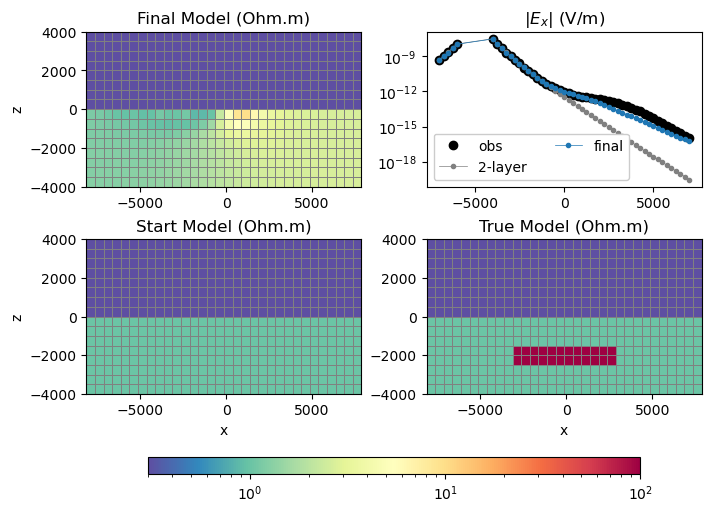

In [168]:
popts = {'edgecolors': 'grey', 'linewidth': 0.5, 'cmap':'Spectral_r','norm':LogNorm(vmin=0.3, vmax=100)}
opts = {'v_type': 'CC', 'normal': 'Y', 'pcolor_opts': popts}

fig, axs = plt.subplots(2, 2, figsize=(7, 5), constrained_layout=True)
(ax1, ax2), (ax3, ax4) = axs

# Final inversion model
out1, = inp_grid.plot_slice(1/np.array(INV.model), ax=ax1, **opts)
ax1.set_title(f"Final Model (Ohm.m)")
ax1.set_xlabel('')

# Start model
out3, = inp_grid.plot_slice(inp_data['model'].property_x.ravel('F'), ax=ax3, **opts)
ax3.set_title(f"Start Model (Ohm.m)")

# True model
out4, = inp_grid.plot_slice(inp_data['true_model'].property_x.ravel('F'), ax=ax4, **opts)
ax4.set_title(f"True Model (Ohm.m)")
ax4.set_ylabel('')

# Data
obs = sim.data.observed
syn = sim.data.inv
syn.data[~np.isfinite(obs.data)] = np.nan+1j*np.nan
two = sim.data.synthetic
two.data[~np.isfinite(obs.data)] = np.nan+1j*np.nan
rec_coords = inp_survey.receiver_coordinates()

for i, src in enumerate(inp_survey.sources.keys()):
    ax2.plot(rec_coords[0], abs(obs.loc[src, :, :].data), "ko", label='obs' if i == 0 else '')
    ax2.plot(rec_coords[0], abs(two.loc[src, :, :].data), ".-", c='.5', lw=0.5, label='2-layer' if i == 0 else '')
    ax2.plot(rec_coords[0], abs(syn.loc[src, :, :].data), f"C{i}.-", lw=0.5, label='final' if i == 0 else '')

ax2.set_yscale('log')
ax2.legend(ncol=2, framealpha=1)
ax2.set_title('$|E_x|$ (V/m)')

plt.colorbar(out1, ax=axs, orientation='horizontal', fraction=.1, shrink=.8, aspect=30);

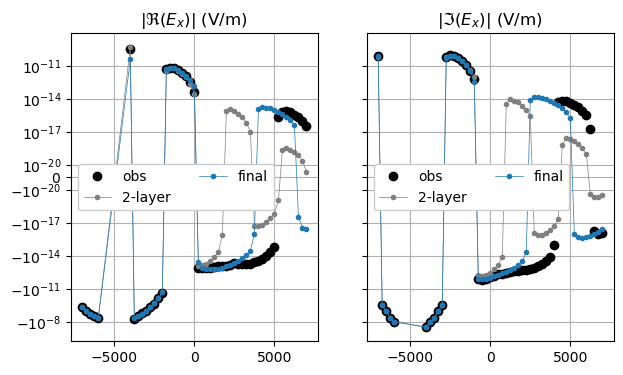

In [175]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4), sharex=True, sharey=True)

for i, src in enumerate(sim.survey.sources.keys()):
    ax1.plot(rec_coords[0], obs.loc[src, :, :].real, "ko", label='obs' if i == 0 else '')
    ax1.plot(rec_coords[0], two.loc[src, :, :].real, ".-", c='.5', lw=0.5, label='2-layer' if i == 0 else '')
    ax1.plot(rec_coords[0], syn.loc[src, :, :].real, f"C{i}.-", lw=0.5, label='final' if i == 0 else '')
    ax2.plot(rec_coords[0], obs.loc[src, :, :].imag, "ko", label='obs' if i == 0 else '')
    ax2.plot(rec_coords[0], two.loc[src, :, :].imag, ".-", c='.5', lw=0.5, label='2-layer' if i == 0 else '')
    ax2.plot(rec_coords[0], syn.loc[src, :, :].imag, f"C{i}.-", lw=0.5, label='final' if i == 0 else '')

ax2.set_yscale('symlog', linthresh=1e-20)
ax1.legend(ncol=2, framealpha=1)
ax2.legend(ncol=2, framealpha=1)
ax1.grid()
ax2.grid()
ax1.set_title('$|\Re(E_x)|$ (V/m)')
ax2.set_title('$|\Im(E_x)|$ (V/m)');

In [170]:
pg.Report('emg3d')

--------------------------------------------------------------------------------
  Date: Thu Dec 14 16:06:00 2023 Mitteleuropäische Zeit

                OS : Windows
            CPU(s) : 20
           Machine : AMD64
      Architecture : 64bit
               RAM : 31.6 GiB
       Environment : Jupyter

  Python 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:28:38) [MSC
  v.1929 64 bit (AMD64)]

             emg3d : unknown-20231214
           pygimli : 0+untagged.4752.g48ce372 (dev)
            pgcore : 1.3.0
             numpy : 1.21.6
        matplotlib : 3.7.1
             scipy : 1.10.1
              tqdm : 4.65.0
           IPython : 8.12.0
            meshio : 5.3.4
           pyvista : 0.39.0
--------------------------------------------------------------------------------

# Parking lot